In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [2]:
# Raw Data
df = pd.read_csv('../data/raw/rating.csv')
df.head(5)

,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [3]:
# Train Data (subset of all interactions)
df = pd.read_csv('../data/interactions_train_df.csv')
df = df[['user_id', 'content_id', 'game', 'view']]
df.head(5)

,user_id,content_id,game,view
0,134,1680,Far Cry 3 Blood Dragon,1
1,2219,1938,Gone Home,1
2,3315,3711,Serious Sam 3 BFE,1
3,3440,4784,Velvet Sundown,1
4,870,4104,Super Hexagon,1


In [4]:
# Content Data of Games
df_game = pd.read_csv('../data/articles_df.csv')
df_game.head(4)

,content_id,game,total_users,total_hours
0,0,007 Legends,1,1.7
1,1,0RBITALIS,3,4.2
2,2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,27.0
3,3,10 Second Ninja,6,11.9


### Create a Matrix of Interactions

In [5]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_df = df.pivot(index   = 'user_id', 
                                 columns = 'content_id', 
                                 values  = 'view').fillna(0)
users_items_matrix_df.head(10)

content_id,0,1,2,3,5,6,7,8,9,10,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
users_items_matrix_df.shape

(3757, 4862)

In [7]:
users_items_matrix_df.values.mean()*100

0.5042609616033342

### Create a Input Content

In [8]:
def split_str(val):
    '''
    Sprint String list
    '''
    tokens = []
    for v in val:
        tokens.extend(v.split(' '))
    return " ".join(tokens)

In [9]:
# Group games per user
user_games = df.groupby('user_id')['game'].apply(list).reset_index()
user_games.head()

# Split games names
user_games['tokens'] = user_games['game'].apply(split_str)
user_games.head(2)

,user_id,game,tokens
0,0,"[Day of Defeat, Half-Life, Counter-Strike Sour...",Day of Defeat Half-Life Counter-Strike Source ...
1,1,"[Ricochet, The Stanley Parable, Thief Gold, To...",Ricochet The Stanley Parable Thief Gold Total ...


In [10]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [11]:
# integer encode the documents
vocab_size   = 100
encoded_docs = [one_hot(d, vocab_size) for d in user_games.tokens]
print(encoded_docs[:2])

[[39, 2, 19, 45, 25, 89, 68, 44, 45, 25, 96, 6, 16, 3, 12, 70, 32, 6, 86, 96, 50, 77, 89, 68, 85, 45, 25, 96, 41, 14, 45, 25, 96, 2, 40, 7, 96, 6, 6, 45, 25, 96, 2, 74, 85, 92, 16, 96], [85, 5, 34, 66, 78, 72, 31, 3, 30, 78, 96, 78, 6, 33, 89, 68, 45, 25, 10, 2, 31, 46, 36, 3, 20, 90, 89, 68, 22, 77, 68, 96, 17, 5, 54, 47, 44, 2, 19, 79, 87, 68, 96, 17, 5, 78, 32, 68, 96, 78, 86, 78, 10, 2, 31, 68, 11, 76, 9, 39, 2, 19, 10, 2, 31, 68, 11, 96, 9, 70, 32, 6, 3, 12, 10, 2, 31, 68, 11, 76, 89, 68, 44, 78, 82, 50, 2, 9, 39, 89, 87, 78, 5, 61, 92, 10, 2, 31, 68, 11, 96]]


In [12]:
# pad documents to a max length of 4 words
max_length  = 50
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[39  2 19 ... 96  0  0]
 [78 10  2 ... 68 11 96]
 [36  5 70 ... 83 45 25]
 ...
 [ 5 70 25 ...  0  0  0]
 [54 17 29 ...  0  0  0]
 [11  2 57 ...  0  0  0]]


## Model

In [186]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, Embedding, Flatten, add
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''
    users_items_matrix, content_info = X

    # Input
    input_layer   = Input(shape=(users_items_matrix.shape[1],), name='UserScore')
    input_content = Input(shape=(content_info.shape[1],), name='Itemcontent')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Content Information
    x_content = Embedding(100, 256, input_length=content_info.shape[1])(input_content)
    x_content = Flatten()(x_content)
    x_content = Dense(256, activation='selu', 
                                name='ItemLatentSpace')(x_content)
    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='UserLatentSpace')(enc)
    
    lat_space= add([lat_space, x_content], name='LatentSpace')
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(users_items_matrix.shape[1], activation='linear', name='UserScorePred')(dec)

    # this model maps an input to its reconstruction
    model = Model([input_layer, input_content], output_layer)    
    
    return model

In [187]:
# input
X = [users_items_matrix_df.values, padded_docs]
y = users_items_matrix_df.values

In [188]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Itemcontent (InputLayer)        (None, 50)           0                                            
__________________________________________________________________________________________________
UserScore (InputLayer)          (None, 4862)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 256)      25600       Itemcontent[0][0]                
__________________________________________________________________________________________________
EncLayer1 (Dense)               (None, 512)          2489856     UserScore[0][0]                  
__________________________________________________________________________________________________
flatten_3 

### Train Model

In [189]:
hist = model.fit(x=X, y=y,
                  epochs=50,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.1)

Train on 3381 samples, validate on 376 samples
Epoch 1/50
3381/3381 [==============================] - 5s 2ms/step - loss: 0.0296 - val_loss: 0.0040
Epoch 2/50
3381/3381 [==============================] - 6s 2ms/step - loss: 0.0191 - val_loss: 0.0032
Epoch 3/50
3381/3381 [==============================] - 7s 2ms/step - loss: 0.0142 - val_loss: 0.0028
Epoch 4/50
3381/3381 [==============================] - 7s 2ms/step - loss: 0.0113 - val_loss: 0.0026
Epoch 5/50
3381/3381 [==============================] - 7s 2ms/step - loss: 0.0096 - val_loss: 0.0024
Epoch 6/50
3381/3381 [==============================] - 7s 2ms/step - loss: 0.0084 - val_loss: 0.0023
Epoch 7/50
3381/3381 [==============================] - 7s 2ms/step - loss: 0.0075 - val_loss: 0.0022
Epoch 8/50
3381/3381 [==============================] - 7s 2ms/step - loss: 0.0069 - val_loss: 0.0021
Epoch 9/50
3381/3381 [==============================] - 7s 2ms/step - loss: 0.0064 - val_loss: 0.0021
Epoch 10/50
3381/3381 [============

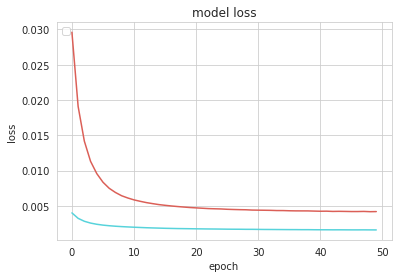

In [190]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])

plot_hist(hist)

## Recommender

In [191]:
# Predict new Matrix Interactions, set score zero on visualized games
new_matrix = model.predict(X) * (X[0] == 0)

In [192]:
# converting the reconstructed matrix back to a Pandas dataframe
new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
                                          columns = users_items_matrix_df.columns, 
                                          index   = users_items_matrix_df.index)
new_users_items_matrix_df.head()

content_id,0,1,2,3,5,6,7,8,9,10,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,-0.001108,0.006268,0.005813,-0.006560,-0.001954,0.004666,0.011587,0.003399,0.009200,-0.004213,...,0.001841,-0.007337,0.002722,0.003359,0.002700,-0.016770,0.000549,-0.006029,-0.027804,0.006544
1,-0.008998,0.006190,-0.001118,0.003761,0.014927,0.016653,0.013542,0.014680,-0.006470,0.005279,...,0.003414,-0.002193,-0.008860,0.012823,-0.003108,0.036262,0.002952,0.008757,0.037994,0.006686
2,-0.001980,0.010168,0.004276,0.009460,0.003864,0.028200,0.001597,0.003032,0.004982,-0.006610,...,0.005684,-0.003128,0.012555,0.018221,-0.009468,0.005207,-0.004904,0.012874,-0.040546,0.010699
3,-0.005784,0.008166,-0.003338,0.001813,-0.003328,0.002030,0.003952,-0.003342,0.008699,-0.005067,...,-0.005938,-0.003720,-0.003846,0.004404,0.000061,-0.005272,0.000266,0.002081,0.010883,0.006152
4,-0.000859,0.002714,-0.004152,-0.003785,-0.001554,-0.004766,-0.001159,-0.009893,0.008515,-0.002823,...,-0.005619,-0.000026,0.002211,0.007410,0.000261,-0.013262,-0.000467,0.000323,0.005825,0.002752


In [193]:
print(new_users_items_matrix_df.values.min(), new_users_items_matrix_df.values.max())

-0.7073772 1.8016256


In [194]:
def recommender_for_user(user_id, interact_matrix, df_content, topn = 10):
    '''
    Recommender Games for UserWarning
    '''
    pred_scores = interact_matrix.loc[user_id].values

    df_scores   = pd.DataFrame({'content_id': list(users_items_matrix_df.columns), 
                               'score': pred_scores})

    df_rec      = df_scores.set_index('content_id')\
                    .join(df_content.set_index('content_id'))\
                    .sort_values('score', ascending=False)\
                    .head(topn)[['score', 'game']]
    
    return df_rec[df_rec.score > 0]

Recommender for **user_id = 1011**. This user prefers games in the same half-life line

In [195]:
# Games previously purchased by the user
recommender_for_user(user_id         = 1011, 
                     interact_matrix = users_items_matrix_df, 
                     df_content      = df_game)

,score,game
content_id,,
3196,1.0,Portal
4221,1.0,Team Fortress 2
2055,1.0,Half-Life 2
2057,1.0,Half-Life 2 Episode One
2059,1.0,Half-Life 2 Lost Coast


In [196]:
# Recommended User Games
recommender_for_user(user_id         = 1011, 
                     interact_matrix = new_users_items_matrix_df, 
                     df_content      = df_game)

,score,game
content_id,,
2058,0.284510,Half-Life 2 Episode Two
2056,0.267194,Half-Life 2 Deathmatch
978,0.189541,Counter-Strike Source
2457,0.161835,Left 4 Dead 2
2062,0.135248,Half-Life Deathmatch Source
3197,0.119243,Portal 2
2456,0.093853,Left 4 Dead
1126,0.089169,Day of Defeat Source
2064,0.082748,Half-Life Source


Recommender for **user_id = 1319**. This user prefers games in the same line as the RPG or strategy

In [197]:
# Games previously purchased by the user
recommender_for_user(user_id         = 1319, 
                     interact_matrix = users_items_matrix_df, 
                     df_content      = df_game)

,score,game
content_id,,
173,1.0,Age of Empires II HD Edition
2662,1.0,Medieval II Total War Kingdoms
4331,1.0,The Elder Scrolls V Skyrim - Hearthfire
4329,1.0,The Elder Scrolls V Skyrim - Dawnguard
4626,1.0,Total War ATTILA
1752,1.0,Football Manager 2015
4272,1.0,The Bard's Tale
4631,1.0,Total War SHOGUN 2
4328,1.0,The Elder Scrolls V Skyrim


In [198]:
# Recommended User Games
recommender_for_user(user_id         = 1319, 
                     interact_matrix = new_users_items_matrix_df, 
                     df_content      = df_game)

,score,game
content_id,,
4330,0.305737,The Elder Scrolls V Skyrim - Dragonborn
3837,0.156768,Skyrim High Resolution Texture Pack
4630,0.106220,Total War ROME II - Emperor Edition
3792,0.103320,Sid Meier's Civilization V
3793,0.102874,Sid Meier's Civilization V Brave New World
1490,0.089144,Empire Total War
4485,0.085225,The Witcher 2 Assassins of Kings Enhanced Edition
4632,0.074669,Total War SHOGUN 2 - Fall of the Samurai
2872,0.072947,Napoleon Total War


## DataViz Latent-Space

In [199]:
model.layers

In [203]:
from keras.models import Model

def get_encoder(model):
    '''
    Return Encoder Model from AutoEncoder Model
    '''
    layer_name = 'LatentSpace'
    encoder    = Model(inputs=model.input,
                       outputs=model.get_layer(layer_name).output)
    return encoder

# Encoder Model
encoder      = get_encoder(model)

# Predict - Transform Input in LantentSpace
latent_space = enc.predict(X)

In [213]:
print(latent_space.shape)
print(latent_space[0])

(3757, 256)
[-0.00088539  0.05945319 -0.11359347 -0.01618869  0.04618068 -0.09307779
  0.00915201  0.11499665  0.03937069  0.02171459 -0.05518773  0.05511439
  0.11921012  0.2148958   0.07757323  0.07551406 -0.09450839  0.02559994
 -0.0580176  -0.12241662  0.00083209 -0.03909268  0.2267525  -0.19018269
 -0.0421067  -0.24428433  0.09002511  0.01425745 -0.02377134  0.02190776
  0.10252534 -0.05826164 -0.03417175 -0.04954806 -0.0310215  -0.00352012
 -0.07508655 -0.04047823 -0.10809474 -0.02088371 -0.0309642   0.07494688
  0.1387741   0.10386743 -0.09007591  0.07635587 -0.03305608  0.11773344
 -0.01550417  0.15977028  0.03023006  0.07202048  0.12679625 -0.06189218
  0.04687973  0.03606249 -0.08607325  0.04301931 -0.09771803 -0.02313944
  0.11923223 -0.11528412  0.21871847  0.11273145 -0.0163737  -0.04993028
  0.14506969 -0.01622262 -0.10840397  0.11121366  0.10204843  0.11478914
 -0.00380488 -0.18746439  0.12812549 -0.11271957  0.04330707 -0.02974727
 -0.05001446  0.02384894  0.0221786  -0

In [205]:
def plt_reduce(x, color = None):
    '''
    Plot Scatter with color
    '''
    plt.figure(figsize=(6, 6))
    plt.scatter(x[:, 0], x[:, 1], c=color,
            alpha=.4, s=3**2, cmap='tab20c')
    plt.grid(False)
    #plt.colorbar()
    plt.show()

In [206]:
from sklearn.manifold import TSNE

# Reduce dimmension
tsne      = TSNE(n_components=2)
x_reduce  = tsne.fit_transform(latent_space)

In [207]:
user_games.head()

,user_id,game,tokens
0,0,"[Day of Defeat, Half-Life, Counter-Strike Sour...",Day of Defeat Half-Life Counter-Strike Source ...
1,1,"[Ricochet, The Stanley Parable, Thief Gold, To...",Ricochet The Stanley Parable Thief Gold Total ...
2,2,"[Deus Ex Game of the Year Edition, Age of Empi...",Deus Ex Game of the Year Edition Age of Empire...
3,3,"[Half-Life Opposing Force, Team Fortress Class...",Half-Life Opposing Force Team Fortress Classic...
4,4,"[Half-Life, Day of Defeat, Half-Life Opposing ...",Half-Life Day of Defeat Half-Life Opposing For...


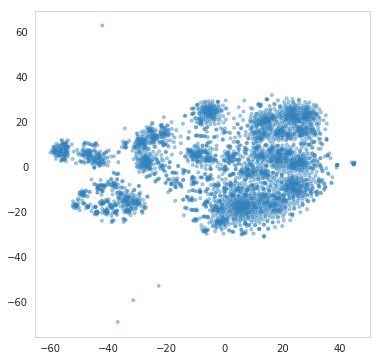

In [208]:
colors = user_games.tokens.str.contains("")
plt_reduce(x_reduce, colors)

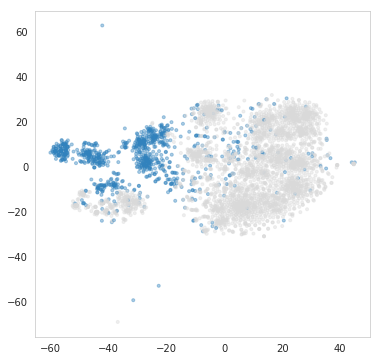

In [209]:
colors = ~user_games.tokens.str\
            .contains("Half-Life")
plt_reduce(x_reduce, colors)

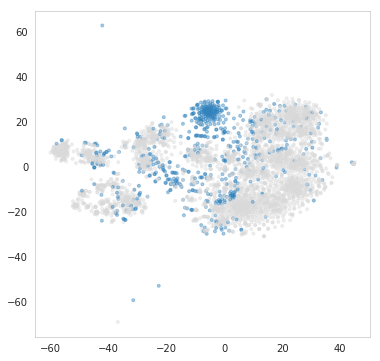

In [210]:
colors = ~user_games.tokens.str\
            .contains("Elder Scrolls")
plt_reduce(x_reduce, colors)